## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # # 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna
# !apt install -y libgl1-mesa-glx
# !pip install albumentations

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter

# import wandb
from datetime import datetime

In [3]:
# [1] 프로젝트 루트 디렉토리 이동 및 환경 설정
import os
os.chdir("../../../")  # 프로젝트 루트로 이동
print("현재 작업 디렉토리:", os.getcwd())

# GPU 체크
import torch
if torch.cuda.is_available():
    print(f'✅ GPU 사용 가능: {torch.cuda.get_device_name(0)}')
else:
    print('⚠️ GPU 사용 불가, CPU로 실행됩니다')

# 경고 억제 설정
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 적용 및 시각화 환경 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 및 설정
font_path = './font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

# 폰트 등록 및 설정 (한글 텍스트 표시를 위함)
fe = fm.FontEntry(fname=font_path, name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams['font.family'] = 'NanumGothic'      # 기본 폰트를 나눔고딕으로 설정
plt.rcParams['font.size'] = 10                   # 기본 글자 크기 설정
plt.rcParams['axes.unicode_minus'] = False       # 마이너스 기호 깨짐 방지

# 글자 겹침 방지를 위한 레이아웃 설정
plt.rcParams['figure.autolayout'] = True         # 자동 레이아웃 조정
plt.rcParams['axes.titlepad'] = 20               # 제목과 축 사이 여백

# 폰트 로드 확인
try:
    test_font = fm.FontProperties(fname=font_path)
    print("✅ 나눔고딕 폰트 로드 성공")
except Exception as e:
    print(f"❌ 폰트 로드 실패: {e}")

# 노트북 로거 생성
from src.logging.notebook_logger import create_notebook_logger

logger = create_notebook_logger(
    base_log_dir="team",
    folder_name="IYS",
    file_name="convnext_large_384"
)

print("✅ 환경 설정 및 로거 초기화 완료")

현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN
✅ GPU 사용 가능: NVIDIA GeForce RTX 4090
✅ 나눔고딕 폰트 로드 성공
📝 노트북 작업 시작: convnext_large_384
📝 로그 디렉토리: notebooks/team/IYS/convnext_large_384/20250912_030622
✅ 환경 설정 및 로거 초기화 완료


In [4]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = './data/raw/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_large_384_in22ft1k'
# model_name = 'convnextv2_base.fcmae_ft_in22k_in1k_384'
# model_name = 'vit_base_patch16_clip_384.laion2b_ft_in12k_in1k' # openclip
# model_name = 'vit_base_patch16_384.augreg_in1k' # augreg
# model_name = 'eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k' # eva-02 멀티모달
# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용
# model_name = 'vit_base_patch14_reg4_dinov2.lvd142m' # dinov2 reg4

# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용

# training config
img_size = 512
LR = 2e-4
EPOCHS = 100
BATCH_SIZE = 10
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("./data/raw/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "./data/raw/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "./data/raw/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 2-Fold Cross Validation...

FOLD 1/2
Train samples: 785, Validation samples: 785


Val Loss: 1.2691: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s]

Epoch  1 | Train Loss: 1.7917 | Train F1: 0.4385 | Val Loss: 0.9087 | Val F1: 0.7617


Fold 1 Best Validation F1: 0.7617

FOLD 2/2
Train samples: 785, Validation samples: 785


Val Loss: 0.6986: 100%|██████████| 79/79 [00:09<00:00,  8.06it/s]

Epoch  1 | Train Loss: 1.8000 | Train F1: 0.4379 | Val Loss: 0.8518 | Val F1: 0.7777


Fold 2 Best Validation F1: 0.7777

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.7617
Fold 2: 0.7777

Mean CV F1: 0.7697 ± 0.0080
Best single fold: 0.7777


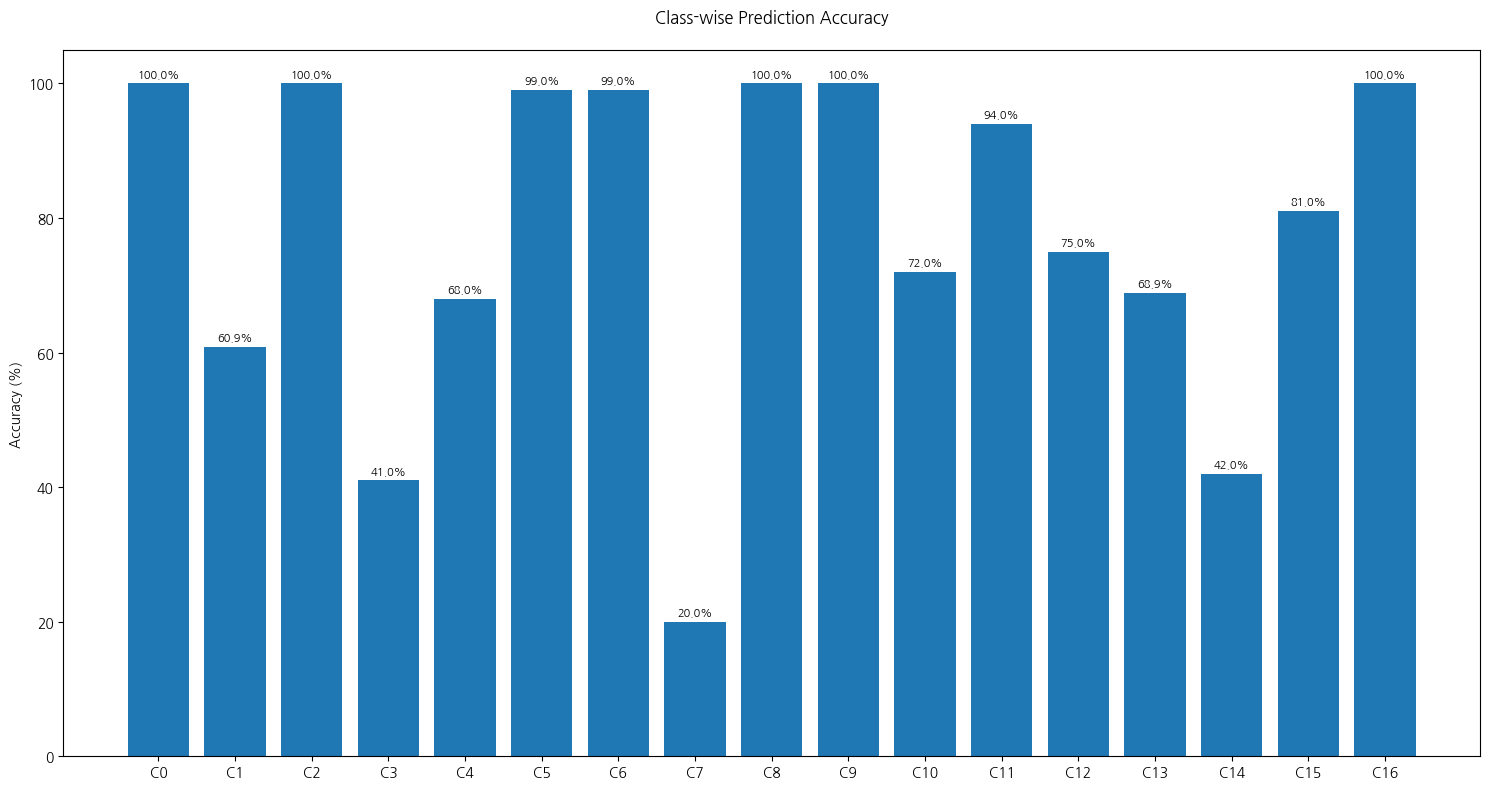

Worst 3 classes:
Class 7: 20.0%
Class 3: 41.0%
Class 14: 42.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("./data/raw/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 디렉토리 생성
os.makedirs('models', exist_ok=True)

# fold_models 저장 (현재 메모리에 있다면 바로 실행 가능)
print("Saving fold models...")
for i, state_dict in enumerate(fold_models):
    save_path = f'models/fold_{i+1}_best.pth'
    torch.save(state_dict, save_path)  # 그냥 직접 저장
    print(f"✓ Fold {i+1} model saved to {save_path}")

print(f"All {len(fold_models)} fold models saved!")

Saving fold models...
✓ Fold 1 model saved to models/fold_1_best.pth
✓ Fold 2 model saved to models/fold_2_best.pth
All 2 fold models saved!


In [14]:
# save_models()

In [15]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 2 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [17]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [18]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [19]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "./data/raw/sample_submission.csv",
    "./data/raw/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=16,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [20]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [21]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 197/197 [07:24<00:00,  2.26s/it]


In [22]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [23]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("./data/raw/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [ ]:
# TTA 결과 저장
tta_pred_df.to_csv("./notebooks/team/IYS/submissions/choice.csv", index=False)
logger.save_dataframe(tta_pred_df, 'convnext_large_384_choice', 'convnext_large_384 파일 TTA 예측 결과 저장')
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [27]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,6
4,00901f504008d884.jpg,2


In [28]:
# =============================================================================
# 📊 K-Fold 결과 분석 (단일 모델 버전)
# =============================================================================

print(f"\n{'='*60}")
print("🏁 K-FOLD 결과 상세 분석")
print(f"{'='*60}")

# 전체 성능 요약
val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

print(f"\n🤖 모델: {model_name}")
print(f"📊 평균 CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"🏆 최고 Fold: {max(val_f1_scores):.4f}")
print(f"📉 최악 Fold: {min(val_f1_scores):.4f}")
print(f"📏 성능 범위: {max(val_f1_scores) - min(val_f1_scores):.4f}")

# Fold별 상세 성능
print(f"\n📋 Fold별 상세 결과:")
print(f"{'📁 Fold':<8} {'🎯 Val F1':<10} {'📈 Train F1':<11} {'👥 Train':<8} {'✅ Val':<7}")
print("─" * 50)

for result in fold_results:
   print(f"   {result['fold']:<5} "
         f"   {result['best_val_f1']:<8.4f} "
         f"   {result['final_train_f1']:<9.4f} "
         f"   {result['train_samples']:<6} "
         f"   {result['val_samples']:<5}")

# 성능 순위
sorted_results = sorted(fold_results, key=lambda x: x['best_val_f1'], reverse=True)
print(f"\n🏅 성능 순위:")
medals = ["🥇", "🥈", "🥉", "🏅", "🏅"]
for i, result in enumerate(sorted_results):
   medal = medals[i] if i < len(medals) else "📍"
   print(f"{medal} {i+1}위: Fold {result['fold']} - F1: {result['best_val_f1']:.4f}")

# 클래스별 성능 분석
if fold_class_accuracies:
   print(f"\n🎯 클래스별 성능 분석:")
   print(f"{'📊 Class':<9} {'📈 평균':<8} {'📏 표준편차':<9} {'🏆 최고':<7} {'📉 최악':<7}")
   print("─" * 45)
   
   class_performance = []
   for class_id in range(17):
       class_accs = []
       for fold_acc in fold_class_accuracies:
           if class_id in fold_acc:
               class_accs.append(fold_acc[class_id])
       
       if class_accs:
           mean_acc = np.mean(class_accs)
           std_acc = np.std(class_accs)
           max_acc = max(class_accs)
           min_acc = min(class_accs)
           
           class_performance.append({
               'class_id': class_id,
               'mean_acc': mean_acc,
               'std_acc': std_acc,
               'max_acc': max_acc,
               'min_acc': min_acc
           })
           
           print(f"   {class_id:<5} "
                 f"   {mean_acc:<6.3f} "
                 f"   {std_acc:<7.3f} "
                 f"   {max_acc:<5.3f} "
                 f"   {min_acc:<5.3f}")
   
   # 어려운 클래스 TOP 3
   worst_classes = sorted(class_performance, key=lambda x: x['mean_acc'])[:3]
   print(f"\n🔴 가장 어려운 클래스 TOP 3:")
   for i, cls in enumerate(worst_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")
   
   # 쉬운 클래스 TOP 3
   best_classes = sorted(class_performance, key=lambda x: x['mean_acc'], reverse=True)[:3]
   print(f"\n🟢 가장 쉬운 클래스 TOP 3:")
   for i, cls in enumerate(best_classes, 1):
       print(f"   {i}. Class {cls['class_id']}: {cls['mean_acc']:.3f} 정확도")

# 성능 일관성 분석
cv_coefficient = std_f1 / mean_f1 if mean_f1 > 0 else 0
print(f"\n⚖️ 성능 일관성 분석:")
print(f"📊 변동계수 (CV): {cv_coefficient:.3f}")

if cv_coefficient < 0.05:
   consistency_emoji = "🟢"
   consistency_text = "매우 일관적인 성능"
elif cv_coefficient < 0.1:
   consistency_emoji = "🔵"
   consistency_text = "일관적인 성능"
elif cv_coefficient < 0.15:
   consistency_emoji = "🟡"
   consistency_text = "보통 수준의 일관성"
else:
   consistency_emoji = "🔴"
   consistency_text = "성능 변동이 큼"

print(f"{consistency_emoji} {consistency_text}")

# 추가 통계
overfit_count = sum(1 for result in fold_results 
                  if result['final_train_f1'] - result['best_val_f1'] > 0.05)

print(f"\n📈 학습 상태 분석:")
print(f"🎯 과적합 의심 Fold: {overfit_count}/{len(fold_results)}개")
if overfit_count > 0:
   print(f"   💡 Train-Val F1 차이가 0.05 이상인 fold 수")

print(f"\n✅ 학습 완료! 총 {len(fold_results)}개 fold 모델 저장됨")
print(f"📁 저장된 모델 파일:")
for i, result in enumerate(fold_results, 1):
   print(f"   📄 {result['model_path']}")

print(f"\n🎉 K-Fold Cross Validation 분석 완료!")


🏁 K-FOLD 결과 상세 분석

🤖 모델: convnext_large_384_in22ft1k
📊 평균 CV F1: 0.7697 ± 0.0080
🏆 최고 Fold: 0.7777
📉 최악 Fold: 0.7617
📏 성능 범위: 0.0160

📋 Fold별 상세 결과:
📁 Fold   🎯 Val F1   📈 Train F1  👥 Train  ✅ Val  
──────────────────────────────────────────────────


KeyError: 'final_train_f1'